# **Predicting the perception of deprivation from VHR Satelite Images.**

**In this part, we load, organize and transform all the input data to the format of input for deep learning model.**

# 1. Import libraries

Firstly, install and import the necessary libraries for this analysis.

In [3]:
import numpy as np
import os, sys
import pandas as pd
import glob
import re
import natsort
import sklearn
import datetime
import cv2
import shutil
import time
import h5py

from osgeo import gdal
from osgeo import gdal_array
from natsort import natsorted
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
from tqdm import tqdm

**Import custom functions**

In [6]:
# Add local module to the path
src = os.path.abspath('../../../SRC')
if src not in sys.path:
    sys.path.append(src)

In [7]:
exec(open(os.path.join(os.environ['HOME'],'project','weak_flair','git_repo','SRC', 'config.py')).read())

In [8]:
# Import functions for processing time information
from processing_time import start_processing, print_processing_time
# Import function that checks and creates folder
from mkdir import check_create_dir
# Import functions for display
from display import Norma_Xpercentile
# Import custom colormap for the label maps
from colormap_matplotlib import Colormap

**Define some functions**

In [9]:
# Check that all images have the same ID
def check_ids(images):
    """Check if all images path have the same ID.

    Keyword arguments:
    *images -- a tuple of list containing the path of the images to be converted
    """
    img_ids = []
    for img in images:
        a = os.path.splitext(os.path.split(img)[-1])[0].split("_")[-1]  # Keep the ID of the image
        img_ids.append(a)
    if len(img_ids) == len([x for x in img_ids if x == img_ids[0]]): # Check if all element of the list are the same as the first element.
        return True
    else:
        return False

In [10]:
# Convert the geotiff to a numpy array
def gtiff_to_array(imgfname):
    """Transform a geotiff to numpy array.

    Keyword arguments:
    imgfnames -- filename of image to convert
    """
    ds = gdal.Open(imgfname)
    for band in range(ds.RasterCount):
        band += 1
        if band == 1:
            arr = np.array(ds.GetRasterBand(band).ReadAsArray())
            arr = np.expand_dims(arr, axis=2)
        else:
            concat = np.array(ds.GetRasterBand(band).ReadAsArray())
            concat = np.expand_dims(concat, axis=2)
            arr = np.concatenate((arr,
                                  concat),
                                 axis=2)
    return arr

In [11]:
# Functions for loading the images and converting them to arrays
def img_to_array(*images):
    """Convert an image or list of images to numpy arrays.

    Keyword arguments:
    *images -- list containing the images to be converted
    """
    imgarrays = []
    for img in images:
        arr = gtiff_to_array(img)
        imgarrays.append(arr)
    return imgarrays

In [12]:
# Normalize the numpy array
def norm_01(data,gmax,gmin):
    """
    rescale the numpy array between [0,1]
    data -- the numpy array
    gmax -- the max value for normalisation
    gmin -- the min value for normalisation
    """
    data = data.astype(float)
    data_norm = (data - gmin)/(gmax - gmin)
    return data_norm

In [13]:
# Tile raw array in patches of specified size
# Trick found here: https://stackoverflow.com/a/45952399/8013239
import cv2
import math

def create_patches(*images, tile_size = (512, 512), offset = (512, 512)):
    """
    Create (tile) patches of specific size from an input numpy array
    *img -- list containing the input numpy array to be tiled
    psize -- the size of the desired patches (number of pixels)
    
    """
    imgarrays = []
    for img in images:
        patches = []
        img_shape = img.shape
        for i in range(int(math.floor(img_shape[0]/(offset[1] * 1.0)))):
            for j in range(int(math.floor(img_shape[1]/(offset[0] * 1.0)))):
                cropped_img = img[offset[1]*i:min(offset[1]*i+tile_size[1], img_shape[0]), offset[0]*j:min(offset[0]*j+tile_size[0], img_shape[1])]
                patches.append(cropped_img)
        imgarrays.append(patches)
    return imgarrays

In [14]:
def Label_to_continuous_int(y,label_dict):
    """
    Convert non-continuous labels into continuous integer, e.g., if you have
    reference image classified with pixels values such as 2,5,6,11,12,41,42 
    it should be converted to 1,2,3,4,5,6,7
    
    Args:
    y -- ground truth image: The array provided should have shape (dimension) as 
    follow: (nbr_patches, nb_rows, nb_cols, 1). Axe 3 should contain the non-continuous labels. 
    label_dict -- dictionnary of correspondances: dictionnary with correspondance between 
    non-continuous labels and continuous integer values.
    
    Returns:
    y -- ground truth image converted to continous integer
    """
    for patch in range(y.shape[0]):
        for i in range(y.shape[1]):
            for j in range(y.shape[2]):
                y[patch, i, j, 0] = label_dict[y[patch, i, j, 0]]
    return y

In [15]:
def save_samplesets(alltrainset, filename, test_ratio=0.2, prob_included=True):
    """Split the set of samples in training and test and save it in an hdf5 file.

    alltrainset -- the array containing all the training samples,
    this will be split into training and validation sets
    alltestset -- the array containing all test samples
    fname -- the filename (and directory) where to write the hdf5
    tp -- the proportional split of training samples
    from alltrainset
    """

    if prob_included:
        # Separate X (Image features - Axis012), y (labels - Axis4) and p (probabilities - Axis3)
        (X_train, p_train, y_train) = (alltrainset[:,:,:,:3],
                                       alltrainset[:,:,:,3],  
                                       alltrainset[:,:,:,4])
        # Change type of X_train to "float32"
        X_train = X_train.astype("float32")
        # Split trainset into training and validation
        X_train, X_test, p_train, p_test, y_train, y_test = train_test_split(X_train, p_train, y_train, test_size=test_ratio, random_state=42)
        # Save the trainng set
        with h5py.File(filename, mode="w") as f:
            f["X_train"] = X_train
            f["X_test"] = X_test
            f["p_train"] = p_train
            f["p_test"] = p_test
            f["y_train"] = y_train
            f["y_test"] = y_test
    else:
        # Separate X (Image features - Axis012) and y (labels - Axis3)
        (X_train, y_train) = (alltrainset[:,:,:,:3],
                              alltrainset[:,:,:,3])
        # Change type of X_train to "float32"
        X_train = X_train.astype("float32")
        # Split trainset into training and validation
        X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=test_ratio, random_state=42)
        # Save the trainng set
        with h5py.File(filename, mode="w") as f:
            f["X_train"] = X_train
            f["X_test"] = X_test
            f["y_train"] = y_train
            f["y_test"] = y_test

In [16]:
import fnmatch

def find_files(path, pattern):
    """Return an generator with the path of all files matching the pattern in the directory and subdirectories.
    path -- the path of the main folder to look for files
    pattern -- the pattern of the file name (e.g. "IMG_*.tif")
    """
    for root, dirs, files in os.walk(path):
        for file in fnmatch.filter(files, pattern):
            yield os.path.join(root, file)

In [17]:
import numpy as np
import rasterio 

def load_tif_images(file_paths):
    """
    Loads a list of .tif images and converts them into numpy arrays.

    Args:
    file_paths (list): A list of file paths to the .tif images.

    Returns:
    list: A list of numpy arrays representing the loaded images.
    """
    images = []
    
    for file_path in file_paths:
        with rasterio.open(file_path) as img:
            img_arr = img.read()
            images.append(img_arr)
    
    return images


def find_min_max(images):
    """
    Finds the minimum and maximum values of a series of images.

    Args:
    images (list): A list of numpy arrays representing the images.

    Returns:
    tuple: A tuple containing the minimum and maximum values of the images.
    """
    min_val = np.inf
    max_val = -np.inf

    for img in images:
        img_min = np.min(img)
        img_max = np.max(img)

        if img_min < min_val:
            min_val = img_min

        if img_max > max_val:
            max_val = img_max

    return min_val, max_val

# 2 Loading, structuring the data

In [18]:
# Define working path 
root = os.path.join(os.environ['HOME'],'project','weak_flair')
train_path = os.path.join(root, 'train')
test_path = os.path.join(root, 'test')
output_path = os.path.join(root, 'experiments', 'DL_results')
data_path = os.path.join(output_path, 'data')
model_path = os.path.join(output_path, 'model')
results_path = os.path.join(output_path, 'results')

In [19]:
#Check and create output data directory if needed
list_directories = [output_path, model_path, results_path, data_path]
for path in list_directories:
    check_create_dir(path)  

The folder '/home/tgrippa/project/weak_flair/experiments/DL_results' already exists
The folder '/home/tgrippa/project/weak_flair/experiments/DL_results/model' already exists
The folder '/home/tgrippa/project/weak_flair/experiments/DL_results/results' already exists
The folder '/home/tgrippa/project/weak_flair/experiments/DL_results/data' already exists


## 2.1 Prepare data for model

In [20]:
def create_numpyarray_hdf5(source_folder, output_path, img_pattern = 'IMG_*.tif', msk_pattern = 'MSK_*.tif'):
    # Create a list of all the filenames of images
    img_list = [x for x in find_files(source_folder,img_pattern)]
    img_list = natsorted(img_list) # Sort the list naturally based on the number in the filename.
    # Create a list of all the filenames of images
    msk_list = [x for x in find_files(source_folder,msk_pattern)]
    msk_list = natsorted(msk_list)
    # Get min and max value for normalization
    gmin,gmax = find_min_max(load_tif_images(img_list)) # Return the global min and max value for all the images in the list (min max, regardless of the band (VNIR+nDSM)
    # Initialize 
    all_set=[] # list for trainsets 
    t0 = time.time() # Save current time
    # Loop on all images/mask pairs
    for a,b in tqdm(list(zip(img_list, msk_list))[:], desc = "Processing"):    
        # Check if all IDs are the same
        if check_ids((a,b)) == False:
            print("Error: IDs are not the same for the different elements")
        # Convert input rasters to numpy Arrays
        images,msk = img_to_array(a,b)
        # Normalise the images values
        images_norm = norm_01(images,gmax,gmin)
        # Concatenate all patches of the current image (axis0=Image_patch; axis1=Blue; axis2=Green; axis3=Red; axis4=SnorkelProba; axis5=SnorkelLabel)
        images_norm = np.asarray(images_norm)  #Turn the list into a numpy array
        msk = np.asarray(msk)    #Turn the list into a numpy array
        patches_set = np.concatenate((images_norm,msk),axis=2)  #Contatenate the ortho, proba and labels of patches of the current image     
        # Append to alltrainset list
        all_set.append(patches_set)

    # Concatenate alltrainset in single array    
    all_set = np.asarray(all_set, dtype=object)
    all_set = all_set.astype("float32") # Change type to "float32"
    #alltrainset = np.concatenate(alltrainset, axis=0)
    print("{total} images have been produced (size {psize}*{psize}, {n_channel} channels)".format(total = all_set.shape[0],
                                                                                                  psize = all_set.shape[1],
                                                                                                  n_channel = all_set.shape[3]))
    # Save the patches in HDF5 file 
    print("\nSaving training patches in .hdf5 file")
    with h5py.File(output_path, mode="w") as f:
        f["all_set"] = all_set
    t1 = time.time()
    print("\nFinished preparing samples after %.2f mins" % ((t1-t0)/60.0))

In [ ]:
create_numpyarray_hdf5(train_path, os.path.join(data_path,"patches_flairlabel.hdf5"), img_pattern = 'IMG_*.tif', msk_pattern = 'MSK_*.tif')

Processing: 100%|█████████████████████████████████| 2950/2950 [00:48<00:00, 61.41it/s]

In [21]:
# Label dictionary
label_dict_snorkel = {-1:0,1:1,2:2,3:3,4:4,5:5}  # Some pixels have value -1 corresponding to ABSTAIN class
label_dict_gts = {1:1,2:2,3:3,4:4,5:5}

### 2.2.1 Fixed threshold

In [25]:
# Find global max (gmax) and glabol min (gmin) values for Top images
gmax = max([gtiff_to_array(x).max() for x in top_list])
gmin = min([gtiff_to_array(x).min() for x in top_list])
print("Global maximum = %s \nGlobal minimum = %s"%(gmax,gmin))

Global maximum = 255 
Global minimum = 0


In [26]:
# Check number of tiles available
num_tiles = len(top_list)
print("Number of tiles to process: %s"%num_tiles)

# Save current time
t0 = time.time()

# Initialize counter
counter = 0
alltrainset=[]

for a,b,c in list(zip(top_list, label_fixed_list, proba_fixed_list))[:]:    
    counter += 1
    print("\nTile %i of %i" % (counter, num_tiles))
    # Check if all IDs are the same
    if check_ids((a,b,c)) == False:
        print("Error: IDs are not the same for the different elements")
    # Convert input rasters to numpy Arrays
    images,labels,proba = img_to_array(a,b,c)
    labels = np.reshape(labels,(labels.shape[0],labels.shape[1])) 
    proba = np.reshape(proba,(proba.shape[0],proba.shape[1]))
    # Normalise the values
    images_norm = norm_01(images,gmax,gmin)
    # Generate image patches
    images_norm,labels,proba = create_patches(images_norm,labels,proba, tile_size=(psize, psize), offset=(psize, psize))
    # Concatenate all patches of the current image (axis0=Image_patch; axis1=Blue; axis2=Green; axis3=Red; axis4=SnorkelProba; axis5=SnorkelLabel)
    images_norm = np.asarray(images_norm)  #Turn the list into a numpy array
    proba = np.asarray(proba)    #Turn the list into a numpy array
    labels = np.asarray(labels)    #Turn the list into a numpy array
    proba = np.expand_dims(proba,axis=3)    #Add one dimension at the end of proba array
    labels = np.expand_dims(labels,axis=3)    #Add one dimension at the end of label array
    labels = Label_to_continuous_int(labels,label_dict_snorkel) #Change labels to continuous intergers
    trainset = np.concatenate((images_norm,proba,labels),axis=3)  #Contatenate the ortho, proba and labels of patches of the current image     
    # Append to alltrainset list
    alltrainset.append(trainset)
    print("{count} patches ({psize}*{psize}) extracted from the current image".format(count=len(trainset),psize=psize))
    
# Concatenate alltrainset in single array    
count_items = len(alltrainset)
alltrainset = np.asarray(alltrainset, dtype=object)
alltrainset = np.concatenate(alltrainset, axis=0)
print("\n%s patches have been extracted from %s images"%(alltrainset.shape[0],count_items))

# Save the patches in HDF5 file 
print("\nStart writing .hdf5 file with training patches")
path = os.path.join(data_path,"patches_fixed_%s.hdf5"%psize)
save_samplesets(alltrainset, path, test_ratio=0.2)

t1 = time.time()
print("\nFinished preparing samples after %.2f mins" % ((t1-t0)/60.0))

Number of tiles to process: 17

Tile 1 of 17
90 patches (256*256) extracted from the current image

Tile 2 of 17
63 patches (256*256) extracted from the current image

Tile 3 of 17
63 patches (256*256) extracted from the current image

Tile 4 of 17
63 patches (256*256) extracted from the current image

Tile 5 of 17
63 patches (256*256) extracted from the current image

Tile 6 of 17
70 patches (256*256) extracted from the current image

Tile 7 of 17
70 patches (256*256) extracted from the current image

Tile 8 of 17
70 patches (256*256) extracted from the current image

Tile 9 of 17
63 patches (256*256) extracted from the current image

Tile 10 of 17
63 patches (256*256) extracted from the current image

Tile 11 of 17
63 patches (256*256) extracted from the current image

Tile 12 of 17
84 patches (256*256) extracted from the current image

Tile 13 of 17
70 patches (256*256) extracted from the current image

Tile 14 of 17
63 patches (256*256) extracted from the current image

Tile 15 of 

In [27]:
# Check shape of final numpy array
print("Shape of the produced array: (%s,%s,%s,%s)"%alltrainset.shape)

Shape of the produced array: (1208,256,256,5)


**Visualise some examples**

In [32]:
# Create the custom colormap for display of label raster
cmap_label,norm_label = Colormap(colors_list=['black','red','yellow','green','cyan','grey'], boundaries=[-1.0,1.0, 2.0, 3.0, 4.0, 5.0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


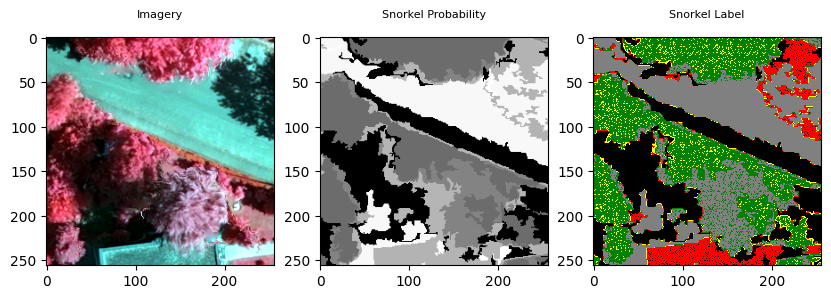

In [42]:
# Plot one random patch extracted
rdm_id = np.random.randint(len(alltrainset))
plt.figure(figsize=(10, 15))
ax = plt.subplot(1, 3, 1)
plt.imshow(Norma_Xpercentile(alltrainset[rdm_id,:,:,0:3],BGR2RGB=False))
plt.title("Imagery", y=1.05, fontsize=8)
ax = plt.subplot(1, 3, 2)
plt.imshow(alltrainset[rdm_id,:,:,3], cmap='gray')  # Proba
plt.title("Snorkel Probability", y=1.05, fontsize=8)
ax = plt.subplot(1, 3, 3)
plt.imshow(alltrainset[rdm_id,:,:,4], cmap=cmap_label, norm=norm_label)  # Labels
plt.title("Snorkel Label", y=1.05, fontsize=8)
plt.subplots_adjust(wspace=0.2,hspace=0.3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


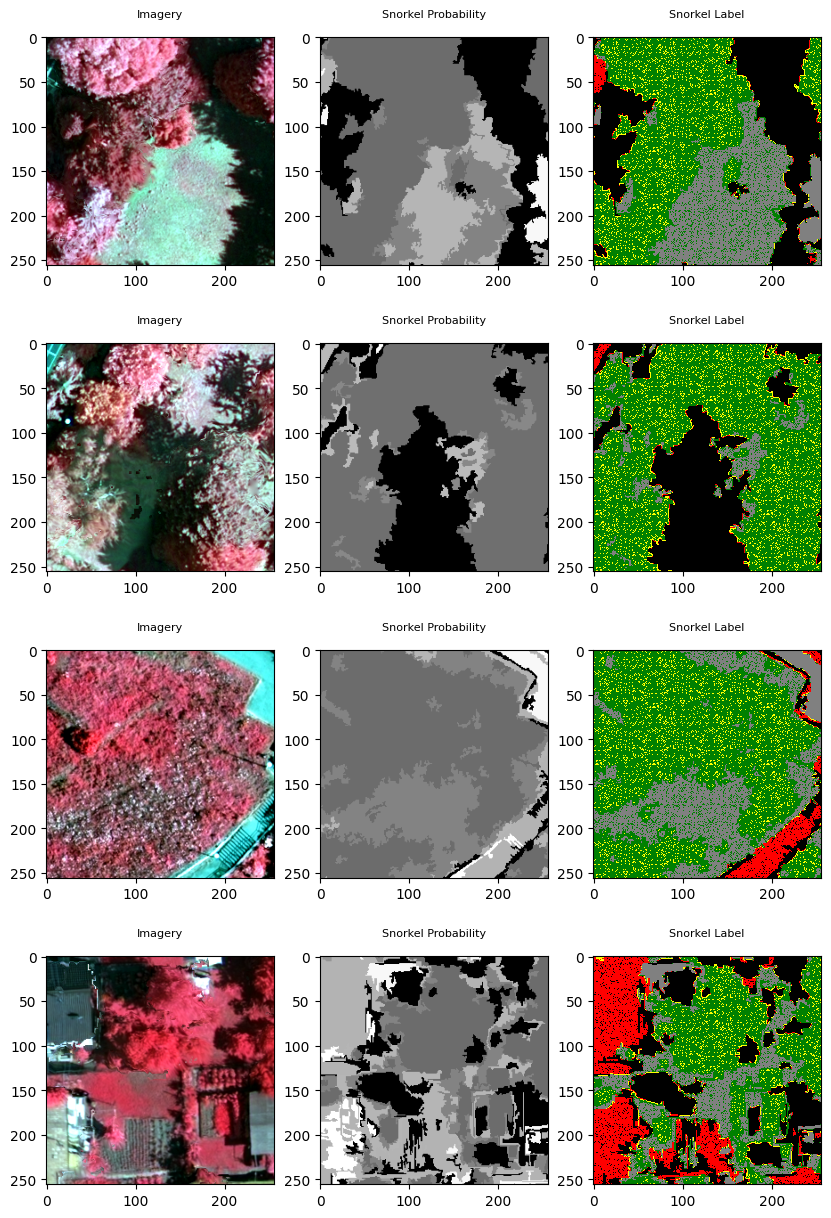

In [43]:
# Plot several random patch extracted
num_example = 4
plt.figure(figsize=(10, 15))
for i in range(num_example):
    i = i*3
    rdm_id = np.random.randint(len(alltrainset))
    ax = plt.subplot(num_example, 3, i+1)
    plt.imshow(Norma_Xpercentile(alltrainset[rdm_id,:,:,0:3],BGR2RGB=False)) # Imagery
    plt.title("Imagery", y=1.05, fontsize=8)
    ax = plt.subplot(num_example, 3, i+2)
    plt.imshow(alltrainset[rdm_id,:,:,3], cmap='gray')  # Proba
    plt.title("Snorkel Probability", y=1.05, fontsize=8)
    ax = plt.subplot(num_example, 3, i+3)
    plt.imshow(alltrainset[rdm_id,:,:,4], cmap=cmap_label, norm=norm_label)  # Labels
    plt.title("Snorkel Label", y=1.05, fontsize=8)
plt.subplots_adjust(wspace=0.2,hspace=0.3)

### 2.2.2 Varying threshold

In [44]:
# Find global max (gmax) and glabol min (gmin) values for Top images
gmax = max([gtiff_to_array(x).max() for x in top_list])
gmin = min([gtiff_to_array(x).min() for x in top_list])
print("Global maximum = %s \nGlobal minimum = %s"%(gmax,gmin))

Global maximum = 255 
Global minimum = 0


In [46]:
# Check number of tiles available
num_tiles = len(top_list)
print("Number of tiles to process: %s"%num_tiles)

# Save current time
t0 = time.time()

# Initialize counter
counter = 0
alltrainset=[]

for a,b,c in list(zip(top_list, label_varying_list, proba_varying_list))[:]:    
    counter += 1
    print("\nTile %i of %i" % (counter, num_tiles))
    # Check if all IDs are the same
    if check_ids((a,b,c)) == False:
        print("Error: IDs are not the same for the different elements")
    # Convert input rasters to numpy Arrays
    images,labels,proba = img_to_array(a,b,c)
    labels = np.reshape(labels,(labels.shape[0],labels.shape[1])) 
    proba = np.reshape(proba,(proba.shape[0],proba.shape[1]))
    # Normalise the values
    images_norm = norm_01(images,gmax,gmin)
    # Generate image patches
    images_norm,labels,proba = create_patches(images_norm,labels,proba, tile_size=(psize, psize), offset=(psize, psize))
    # Concatenate all patches of the current image (axis0=Image_patch; axis1=Blue; axis2=Green; axis3=Red; axis4=SnorkelProba; axis5=SnorkelLabel)
    images_norm = np.asarray(images_norm)  #Turn the list into a numpy array
    proba = np.asarray(proba)    #Turn the list into a numpy array
    labels = np.asarray(labels)    #Turn the list into a numpy array
    proba = np.expand_dims(proba,axis=3)    #Add one dimension at the end of proba array
    labels = np.expand_dims(labels,axis=3)    #Add one dimension at the end of label array
    trainset = np.concatenate((images_norm,proba,labels),axis=3)  #Contatenate the ortho, proba and labels of patches of the current image     
    # Append to alltrainset list
    alltrainset.append(trainset)
    print("{count} patches ({psize}*{psize}) extracted from the current image".format(count=len(trainset),psize=psize))
    
# Concatenate alltrainset in single array    
count_items = len(alltrainset)
alltrainset = np.asarray(alltrainset, dtype=object)
alltrainset = np.concatenate(alltrainset, axis=0)
print("\n%s patches have been extracted from %s images"%(alltrainset.shape[0],count_items))

# Save the patches in HDF5 file 
print("\nStart writing .hdf5 file with training patches")
path = os.path.join(data_path,"patches_varying_%s.hdf5"%psize)
save_samplesets(alltrainset, path, test_ratio=0.2)

t1 = time.time()
print("\nFinished preparing samples after %.2f mins" % ((t1-t0)/60.0))

Number of tiles to process: 17

Tile 1 of 17
90 patches (256*256) extracted from the current image

Tile 2 of 17
63 patches (256*256) extracted from the current image

Tile 3 of 17
63 patches (256*256) extracted from the current image

Tile 4 of 17
63 patches (256*256) extracted from the current image

Tile 5 of 17
63 patches (256*256) extracted from the current image

Tile 6 of 17
70 patches (256*256) extracted from the current image

Tile 7 of 17
70 patches (256*256) extracted from the current image

Tile 8 of 17
70 patches (256*256) extracted from the current image

Tile 9 of 17
63 patches (256*256) extracted from the current image

Tile 10 of 17
63 patches (256*256) extracted from the current image

Tile 11 of 17
63 patches (256*256) extracted from the current image

Tile 12 of 17
84 patches (256*256) extracted from the current image

Tile 13 of 17
70 patches (256*256) extracted from the current image

Tile 14 of 17
63 patches (256*256) extracted from the current image

Tile 15 of 

In [47]:
# Check shape of final numpy array
print("Shape of the produced array: (%s,%s,%s,%s)"%alltrainset.shape)

Shape of the produced array: (1208,256,256,5)


**Visualise some examples**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


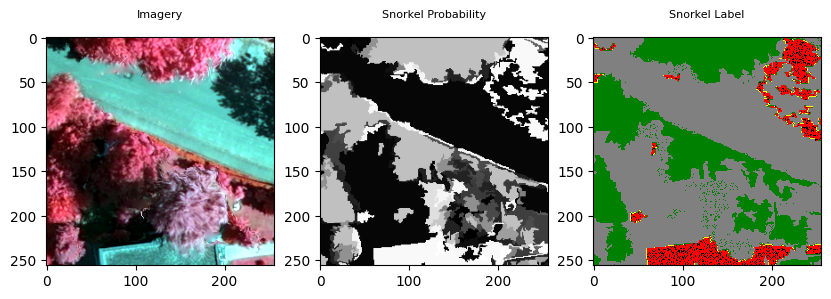

In [48]:
# Plot one random patch extracted
rdm_id = np.random.randint(len(alltrainset))
plt.figure(figsize=(10, 15))
ax = plt.subplot(1, 3, 1)
plt.imshow(Norma_Xpercentile(alltrainset[rdm_id,:,:,0:3],BGR2RGB=False))
plt.title("Imagery", y=1.05, fontsize=8)
ax = plt.subplot(1, 3, 2)
plt.imshow(alltrainset[rdm_id,:,:,3], cmap='gray')  # Proba
plt.title("Snorkel Probability", y=1.05, fontsize=8)
ax = plt.subplot(1, 3, 3)
plt.imshow(alltrainset[rdm_id,:,:,4], cmap=cmap_label, norm=norm_label)  # Labels
plt.title("Snorkel Label", y=1.05, fontsize=8)
plt.subplots_adjust(wspace=0.2,hspace=0.3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


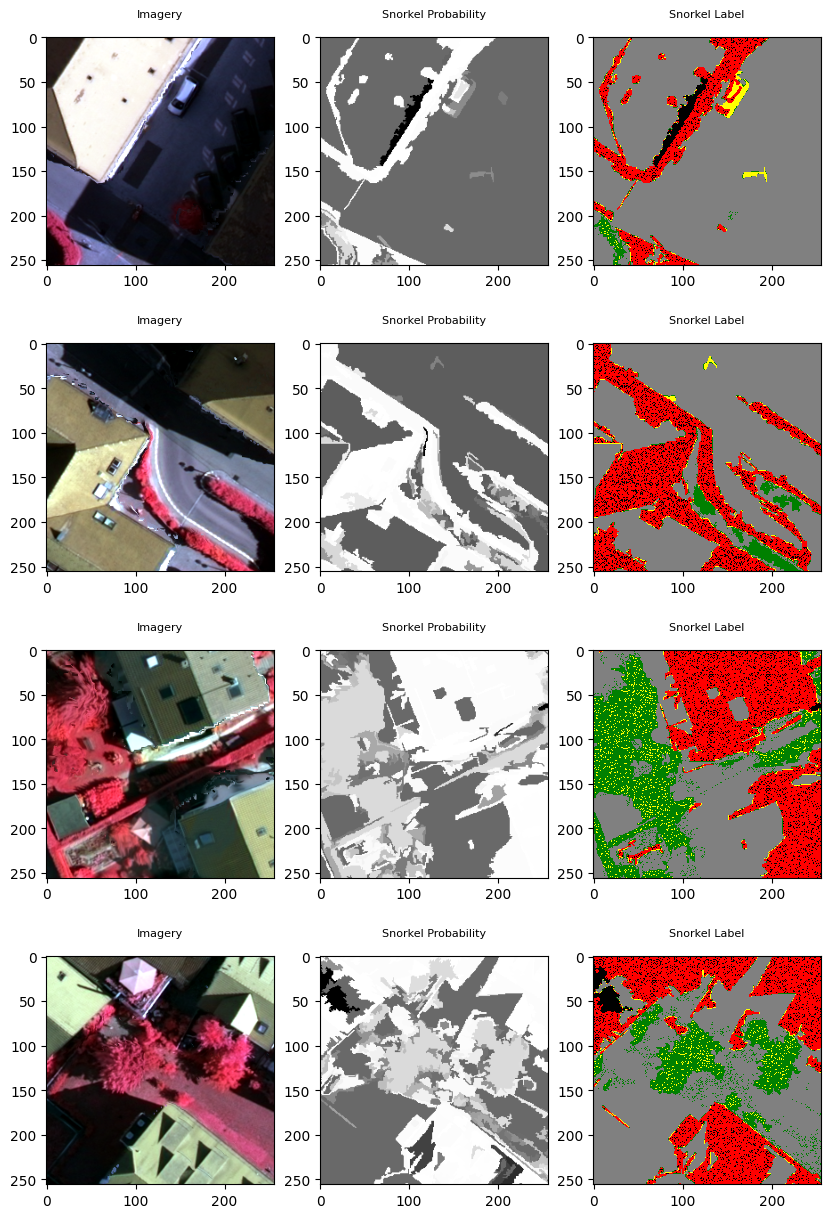

In [49]:
# Plot several random patch extracted
num_example = 4
plt.figure(figsize=(10, 15))
for i in range(num_example):
    i = i*3
    rdm_id = np.random.randint(len(alltrainset))
    ax = plt.subplot(num_example, 3, i+1)
    plt.imshow(Norma_Xpercentile(alltrainset[rdm_id,:,:,0:3],BGR2RGB=False)) # Imagery
    plt.title("Imagery", y=1.05, fontsize=8)
    ax = plt.subplot(num_example, 3, i+2)
    plt.imshow(alltrainset[rdm_id,:,:,3], cmap='gray')  # Proba
    plt.title("Snorkel Probability", y=1.05, fontsize=8)
    ax = plt.subplot(num_example, 3, i+3)
    plt.imshow(alltrainset[rdm_id,:,:,4], cmap=cmap_label, norm=norm_label)  # Labels
    plt.title("Snorkel Label", y=1.05, fontsize=8)
plt.subplots_adjust(wspace=0.2,hspace=0.3)

### 2.2.3 Ground Truth sample

In [50]:
# Create a list of all the filenames of images
top_list = [x for x in glob.glob(os.path.join(image_path,"*.tif"))]
# Keep only images used for the classical approach (DL model trained with the Vaihingen Ground Truth dataset)
wanted_ids = config_parameters['images_classical_approach']
top_list = [x for x in top_list if os.path.splitext(x)[0].split("_area")[-1] in wanted_ids]
# Sort the list naturally based on the number in the filename.
top_list = natsorted(top_list)
top_list

['/home/tais/data/ISPRS_semantic_labeling_Vaihingen/top/top_mosaic_09cm_area1.tif',
 '/home/tais/data/ISPRS_semantic_labeling_Vaihingen/top/top_mosaic_09cm_area5.tif',
 '/home/tais/data/ISPRS_semantic_labeling_Vaihingen/top/top_mosaic_09cm_area7.tif',
 '/home/tais/data/ISPRS_semantic_labeling_Vaihingen/top/top_mosaic_09cm_area11.tif',
 '/home/tais/data/ISPRS_semantic_labeling_Vaihingen/top/top_mosaic_09cm_area15.tif',
 '/home/tais/data/ISPRS_semantic_labeling_Vaihingen/top/top_mosaic_09cm_area21.tif',
 '/home/tais/data/ISPRS_semantic_labeling_Vaihingen/top/top_mosaic_09cm_area23.tif',
 '/home/tais/data/ISPRS_semantic_labeling_Vaihingen/top/top_mosaic_09cm_area28.tif',
 '/home/tais/data/ISPRS_semantic_labeling_Vaihingen/top/top_mosaic_09cm_area30.tif',
 '/home/tais/data/ISPRS_semantic_labeling_Vaihingen/top/top_mosaic_09cm_area34.tif']

In [51]:
# Create a list of all the filenames of images
label_gts_list = [x for x in glob.glob(os.path.join(root, "data", "ISPRS_semantic_labeling_Vaihingen","gts_for_participants_labels","gts_image_*.tif"))]
# Keep only images used for the classical approach (DL model trained with the Vaihingen Ground Truth dataset)
wanted_ids = config_parameters['images_classical_approach']
label_gts_list = [x for x in label_gts_list if os.path.splitext(x)[0].split("_")[-1] in wanted_ids]
# Sort the list naturally based on the number in the filename.
label_gts_list = natsorted(label_gts_list)
label_gts_list

['/home/tais/data/ISPRS_semantic_labeling_Vaihingen/gts_for_participants_labels/gts_image_1.tif',
 '/home/tais/data/ISPRS_semantic_labeling_Vaihingen/gts_for_participants_labels/gts_image_5.tif',
 '/home/tais/data/ISPRS_semantic_labeling_Vaihingen/gts_for_participants_labels/gts_image_7.tif',
 '/home/tais/data/ISPRS_semantic_labeling_Vaihingen/gts_for_participants_labels/gts_image_11.tif',
 '/home/tais/data/ISPRS_semantic_labeling_Vaihingen/gts_for_participants_labels/gts_image_15.tif',
 '/home/tais/data/ISPRS_semantic_labeling_Vaihingen/gts_for_participants_labels/gts_image_21.tif',
 '/home/tais/data/ISPRS_semantic_labeling_Vaihingen/gts_for_participants_labels/gts_image_23.tif',
 '/home/tais/data/ISPRS_semantic_labeling_Vaihingen/gts_for_participants_labels/gts_image_28.tif',
 '/home/tais/data/ISPRS_semantic_labeling_Vaihingen/gts_for_participants_labels/gts_image_30.tif',
 '/home/tais/data/ISPRS_semantic_labeling_Vaihingen/gts_for_participants_labels/gts_image_34.tif']

In [57]:
# Find global max (gmax) and glabol min (gmin) values for Top images
gmax = max([gtiff_to_array(x).max() for x in top_list])
gmin = min([gtiff_to_array(x).min() for x in top_list])
print("Global maximum = %s \nGlobal minimum = %s"%(gmax,gmin))

Global maximum = 255 
Global minimum = 0


In [58]:
# Check number of tiles available
num_tiles = len(top_list)
print("Number of tiles to process: %s"%num_tiles)

# Save current time
t0 = time.time()

# Initialize counter
counter = 0
alltrainset=[]

for a,b in list(zip(top_list, label_gts_list))[:]:    
    counter += 1
    print("\nTile %i of %i" % (counter, num_tiles))
    # Check if all IDs are the same
    if check_ids((a,b)) == False:
        print("Error: IDs are not the same for the different elements")
    # Convert input rasters to numpy Arrays
    images,labels = img_to_array(a,b)
#    labels = np.reshape(labels,(labels.shape[0],labels.shape[1])) 
    # Normalise the values
    images_norm = norm_01(images,gmax,gmin)
    # Generate image patches
    images_norm,labels = create_patches(images_norm,labels, tile_size=(psize, psize), offset=(psize, psize))
    # Concatenate all patches of the current image (axis0=Image_patch; axis1=Blue; axis2=Green; axis3=Red; axis4=SnorkelProba; axis5=SnorkelLabel)
    images_norm = np.asarray(images_norm)  #Turn the list into a numpy array
    labels = np.asarray(labels)    #Turn the list into a numpy array
#    labels = np.expand_dims(labels,axis=3)    #Add one dimension at the end of label array
    trainset = np.concatenate((images_norm,labels),axis=3)  #Contatenate the ortho, proba and labels of patches of the current image     
    # Append to alltrainset list
    alltrainset.append(trainset)
    print("{count} patches ({psize}*{psize}) extracted from the current image".format(count=len(trainset),psize=psize))
    
# Concatenate alltrainset in single array    
count_items = len(alltrainset)
alltrainset = np.asarray(alltrainset, dtype=object)
alltrainset = np.concatenate(alltrainset, axis=0)
print("\n%s patches have been extracted from %s images"%(alltrainset.shape[0],count_items))

# Save the patches in HDF5 file 
print("\nStart writing .hdf5 file with training patches")
path = os.path.join(data_path,"patches_gts_classicalapproach_%s.hdf5"%psize)
save_samplesets(alltrainset, path, test_ratio=0.2, prob_included=False)  # No probability in the numpy array, so prob_included=False

t1 = time.time()
print("\nFinished preparing samples after %.2f mins" % ((t1-t0)/60.0))

Number of tiles to process: 10

Tile 1 of 10
Error: IDs are not the same for the different elements
70 patches (256*256) extracted from the current image

Tile 2 of 10
Error: IDs are not the same for the different elements
63 patches (256*256) extracted from the current image

Tile 3 of 10
Error: IDs are not the same for the different elements
63 patches (256*256) extracted from the current image

Tile 4 of 10
Error: IDs are not the same for the different elements
70 patches (256*256) extracted from the current image

Tile 5 of 10
Error: IDs are not the same for the different elements
70 patches (256*256) extracted from the current image

Tile 6 of 10
Error: IDs are not the same for the different elements
63 patches (256*256) extracted from the current image

Tile 7 of 10
Error: IDs are not the same for the different elements
63 patches (256*256) extracted from the current image

Tile 8 of 10
Error: IDs are not the same for the different elements
70 patches (256*256) extracted from the

In [59]:
# Check shape of final numpy array
print("Shape of the produced array: (%s,%s,%s,%s)"%alltrainset.shape)

Shape of the produced array: (647,256,256,4)


**Visualise some examples**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


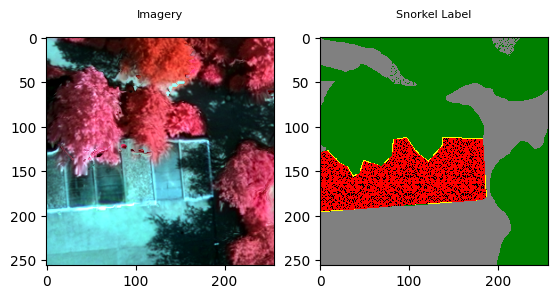

In [63]:
# Plot one random patch extracted
rdm_id = np.random.randint(len(alltrainset))
plt.figure(figsize=(10, 20))
ax = plt.subplot(1, 3, 1)
plt.imshow(Norma_Xpercentile(alltrainset[rdm_id,:,:,0:3],BGR2RGB=False))
plt.title("Imagery", y=1.05, fontsize=8)
ax = plt.subplot(1, 3, 2)
plt.imshow(alltrainset[rdm_id,:,:,3], cmap=cmap_label, norm=norm_label)  # Labels
plt.title("Snorkel Label", y=1.05, fontsize=8)
plt.subplots_adjust(wspace=0.2,hspace=0.3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


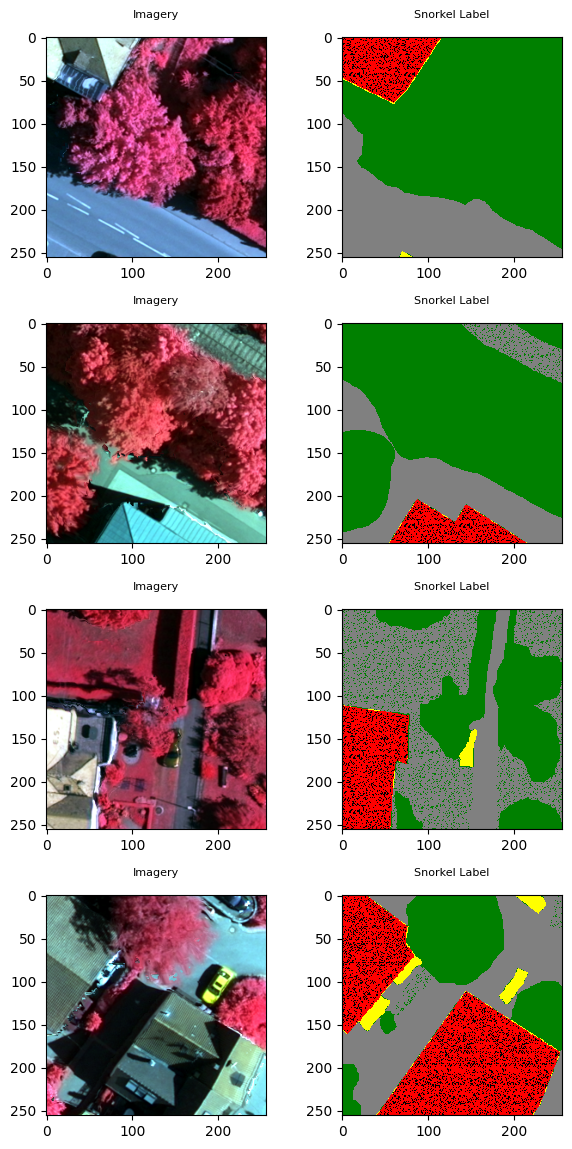

In [67]:
# Plot several random patch extracted
num_example = 4
plt.figure(figsize=(7, 14))
for i in range(num_example):
    i = i*2
    rdm_id = np.random.randint(len(alltrainset))
    ax = plt.subplot(num_example, 2, i+1)
    plt.imshow(Norma_Xpercentile(alltrainset[rdm_id,:,:,0:3],BGR2RGB=False)) # Imagery
    plt.title("Imagery", y=1.05, fontsize=8)
    ax = plt.subplot(num_example, 2, i+2)
    plt.imshow(alltrainset[rdm_id,:,:,3], cmap=cmap_label, norm=norm_label)  # Labels
    plt.title("Snorkel Label", y=1.05, fontsize=8)
plt.subplots_adjust(wspace=0.2,hspace=0.3)

## 2.3 Check HDF5 file